In [1]:
import boto3
import pandas as pd
import os
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import seaborn as sns
# Set a random seed for reproducibility
np.random.seed(42)

c:\Users\Dell\Documents\Mlops-Project\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
bucket_name = 'my-feature-store-data'
data_key = 'raw-data/aqi_weather_data.csv'
        # Create S3 client
s3 = boto3.client(
    's3',
    aws_access_key_id=os.getenv('AWS_ACCESS_KEY_ID'),
    aws_secret_access_key=os.getenv('AWS_SECRET_ACCESS_KEY'),
)
# Download the file from S3
s3.download_file(bucket_name, data_key, '../data/raw/aqi_weather_data.csv')
# Read the CSV file into a DataFrame
df = pd.read_csv('../data/raw/aqi_weather_data.csv')

In [3]:
print(df.tail())

      aqi_index      co    no   no2      o3   so2  pm2_5    pm10   nh3  \
4774        3.0   90.40  0.00  0.06   44.68  0.29  12.55   64.77  0.01   
4775        3.0   89.68  0.00  0.07   44.05  0.30  13.12   65.45  0.01   
4776        4.0  237.68  0.00  2.03   99.69  1.69  43.95  106.48  0.65   
4777        4.0  237.68  0.00  2.03   99.69  1.69  43.95  106.48  0.65   
4778        4.0  421.02  0.25  4.78  100.71  8.70  70.64  168.08  2.78   

      temperature_2m  ...  surface_pressure  dew_point_2m  \
4774            29.1  ...             997.6          25.5   
4775            28.7  ...             997.6          25.7   
4776            25.5  ...            1011.2          19.2   
4777            25.5  ...            1011.2          19.1   
4778            27.8  ...            1013.4          17.0   

      apparent_temperature  shortwave_radiation  et0_fao_evapotranspiration  \
4774                  34.2                  0.0                        0.04   
4775                  34.1    

In [4]:
print(df.shape)

(4779, 24)


In [5]:
# Overview
df.info()

# Summary stats
df.describe()

# Check for nulls
df.isnull().sum()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4779 entries, 0 to 4778
Data columns (total 24 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   aqi_index                   4563 non-null   float64
 1   co                          4563 non-null   float64
 2   no                          4563 non-null   float64
 3   no2                         4563 non-null   float64
 4   o3                          4563 non-null   float64
 5   so2                         4563 non-null   float64
 6   pm2_5                       4563 non-null   float64
 7   pm10                        4563 non-null   float64
 8   nh3                         4563 non-null   float64
 9   temperature_2m              4739 non-null   float64
 10  relative_humidity_2m        4739 non-null   float64
 11  precipitation               4739 non-null   float64
 12  wind_speed_10m              4739 non-null   float64
 13  wind_direction_10m          4739 

aqi_index                      216
co                             216
no                             216
no2                            216
o3                             216
so2                            216
pm2_5                          216
pm10                           216
nh3                            216
temperature_2m                  40
relative_humidity_2m            40
precipitation                   40
wind_speed_10m                  40
wind_direction_10m              40
surface_pressure                40
dew_point_2m                    41
apparent_temperature            40
shortwave_radiation             40
et0_fao_evapotranspiration      40
year                           216
month                          216
day                            216
hour                           216
cloudcover                    4776
dtype: int64

In [6]:
# Summary of missing values
missing_summary = df.isna().sum().sort_values(ascending=False)
print("\nMissing Value Summary:\n", missing_summary)


Missing Value Summary:
 cloudcover                    4776
aqi_index                      216
no                             216
co                             216
o3                             216
so2                            216
pm2_5                          216
no2                            216
pm10                           216
nh3                            216
year                           216
month                          216
day                            216
hour                           216
dew_point_2m                    41
relative_humidity_2m            40
surface_pressure                40
wind_direction_10m              40
wind_speed_10m                  40
precipitation                   40
temperature_2m                  40
et0_fao_evapotranspiration      40
apparent_temperature            40
shortwave_radiation             40
dtype: int64


In [7]:
# drop repeated rows
df = df.drop_duplicates()

In [8]:
# Step 1: Drop columns with all values missing (4336 rows)
threshold = len(df)
drop_cols = missing_summary[missing_summary == threshold].index.tolist()
df.drop(columns=drop_cols, inplace=True)
print(f"\nDropped columns with all values missing: {drop_cols}")


Dropped columns with all values missing: []


In [9]:
# Step 3: Imputation

# Time-based interpolation for weather features
time_features = [
    "temperature_2m", "relative_humidity_2m", "precipitation", "wind_speed_10m",
    "wind_direction_10m", "surface_pressure", "dew_point_2m",
    "apparent_temperature", "shortwave_radiation", "et0_fao_evapotranspiration"
]


In [10]:
df.isnull().sum()

aqi_index                      216
co                             216
no                             216
no2                            216
o3                             216
so2                            216
pm2_5                          216
pm10                           216
nh3                            216
temperature_2m                  40
relative_humidity_2m            40
precipitation                   40
wind_speed_10m                  40
wind_direction_10m              40
surface_pressure                40
dew_point_2m                    41
apparent_temperature            40
shortwave_radiation             40
et0_fao_evapotranspiration      40
year                           216
month                          216
day                            216
hour                           216
cloudcover                    4774
dtype: int64

In [11]:
import pandas as pd
import numpy as np

class RelevantEnvironmentalImputer:
    def __init__(self, data_path):
        self.df = pd.read_csv(data_path)
    
    def impute(self):
        columns = [
            'aqi_index', 'co', 'no', 'no2', 'o3', 'so2',
            'pm2_5', 'pm10', 'nh3', 'temperature_2m', 'relative_humidity_2m',
            'precipitation', 'wind_speed_10m', 'wind_direction_10m',
            'surface_pressure', 'dew_point_2m', 'apparent_temperature',
            'shortwave_radiation', 'et0_fao_evapotranspiration', 'year', 'month',
            'day', 'hour'
        ]
        
        self.df = self.df[columns]
        
        # Timestamp imputation
        if 'year' in self.df.columns:
            self.df['year'] = self.df['year'].fillna(method='ffill')
        if 'month' in self.df.columns:
            self.df['month'] = self.df['month'].fillna(method='ffill')
        if 'day' in self.df.columns:
            self.df['day'] = self.df['day'].fillna(method='ffill')
        if 'hour' in self.df.columns:
            self.df['hour'] = self.df['hour'].fillna(method='ffill')

        # Pollutants
        pollutants = ['co', 'no', 'no2', 'o3', 'so2', 'pm2_5', 'pm10', 'nh3', 'aqi_index']
        for col in pollutants:
            if col in self.df.columns:
                self.df[col] = self.df[col].interpolate(method='linear', limit_direction='both')

        # Temperature related
        temp_features = ['temperature_2m', 'dew_point_2m', 'apparent_temperature']
        for col in temp_features:
            if col in self.df.columns:
                self.df[col] = self.df[col].interpolate(method='linear', limit_direction='both')

        # Atmospheric conditions
        atmosphere = ['relative_humidity_2m', 'surface_pressure']
        for col in atmosphere:
            if col in self.df.columns:
                self.df[col] = self.df[col].interpolate(method='linear', limit_direction='both')

        # Precipitation
        if 'precipitation' in self.df.columns:
            self.df['precipitation'] = self.df['precipitation'].fillna(0)

        # Wind speed
        if 'wind_speed_10m' in self.df.columns:
            self.df['wind_speed_10m'] = self.df['wind_speed_10m'].interpolate(method='linear', limit_direction='both')

        # Wind direction (forward fill — direction can persist)
        if 'wind_direction_10m' in self.df.columns:
            self.df['wind_direction_10m'] = self.df['wind_direction_10m'].fillna(method='ffill')

        # Shortwave radiation — 0 during night, interpolate during day
        if 'shortwave_radiation' in self.df.columns:
            self._impute_shortwave_radiation()

        # ET0 Evapotranspiration — 0 during night, interpolate during day
        if 'et0_fao_evapotranspiration' in self.df.columns:
            self._impute_et0()

        return self.df

    def _impute_shortwave_radiation(self):
        radiation = self.df['shortwave_radiation']
        # Assume if shortwave radiation < 1 → it's night
        night_mask = (radiation < 1) | (self.df['shortwave_radiation'].isna())
        self.df.loc[night_mask, 'shortwave_radiation'] = 0
        self.df['shortwave_radiation'] = self.df['shortwave_radiation'].interpolate(method='linear', limit_direction='both')

    def _impute_et0(self):
        et0 = self.df['et0_fao_evapotranspiration']
        # Assume if shortwave radiation = 0 → it's night (thus et0 should be 0)
        if 'shortwave_radiation' in self.df.columns:
            night_mask = (self.df['shortwave_radiation'] == 0)
            self.df.loc[night_mask, 'et0_fao_evapotranspiration'] = 0
        self.df['et0_fao_evapotranspiration'] = self.df['et0_fao_evapotranspiration'].interpolate(method='linear', limit_direction='both')

imputer = RelevantEnvironmentalImputer('../data/raw/aqi_weather_data.csv')
imputed_data = imputer.impute()
print("Relevant imputation complete!")


Relevant imputation complete!


C:\Users\Dell\AppData\Local\Temp\ipykernel_4332\2844705223.py:22: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  self.df['year'] = self.df['year'].fillna(method='ffill')
C:\Users\Dell\AppData\Local\Temp\ipykernel_4332\2844705223.py:24: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  self.df['month'] = self.df['month'].fillna(method='ffill')
C:\Users\Dell\AppData\Local\Temp\ipykernel_4332\2844705223.py:26: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  self.df['day'] = self.df['day'].fillna(method='ffill')
C:\Users\Dell\AppData\Local\Temp\ipykernel_4332\2844705223.py:28: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  self.df['hour'] = self.df

In [12]:
import pandas as pd
df = imputed_data
# PM2.5 breakpoints
pm25_breakpoints = [
    (0.0, 12.0, 0, 50),
    (12.1, 35.4, 51, 100),
    (35.5, 55.4, 101, 150),
    (55.5, 150.4, 151, 200),
    (150.5, 250.4, 201, 300),
    (250.5, 350.4, 301, 400),
    (350.5, 500.4, 401, 500),
]

# Similarly define pm10_breakpoints, no2_breakpoints, o3_breakpoints, so2_breakpoints, co_breakpoints...

# --- AQI Calculation function ---
def calculate_individual_aqi(concentration, breakpoints):
    for bp in breakpoints:
        c_low, c_high, i_low, i_high = bp
        if c_low <= concentration <= c_high:
            return round(((i_high - i_low) / (c_high - c_low)) * (concentration - c_low) + i_low)
    return None

# --- Apply to each row ---
aqi_list = []

for _, row in df.iterrows():
    pm25_aqi = calculate_individual_aqi(row['pm2_5'], pm25_breakpoints)
    pm10_aqi = calculate_individual_aqi(row['pm10'], pm25_breakpoints)
    no2_aqi = calculate_individual_aqi(row['no2'], pm25_breakpoints)
    o3_aqi = calculate_individual_aqi(row['o3'], pm25_breakpoints)
    so2_aqi = calculate_individual_aqi(row['so2'], pm25_breakpoints)
    co_aqi = calculate_individual_aqi(row['co'], pm25_breakpoints)
    nh3_aqi = calculate_individual_aqi(row['nh3'], pm25_breakpoints)
    # Similarly for pm10_aqi, no2_aqi, o3_aqi, so2_aqi, co_aqi
    
    aqi_values = [value for value in [pm25_aqi, pm10_aqi, no2_aqi, o3_aqi, so2_aqi, co_aqi] if value is not None]
    if aqi_values:
        final_aqi = max(aqi_values)
    else:
        final_aqi = None
    
    aqi_list.append(final_aqi)

df['Calculated_AQI'] = aqi_list

In [13]:
print(df.isna().sum())

aqi_index                     0
co                            0
no                            0
no2                           0
o3                            0
so2                           0
pm2_5                         0
pm10                          0
nh3                           0
temperature_2m                0
relative_humidity_2m          0
precipitation                 0
wind_speed_10m                0
wind_direction_10m            0
surface_pressure              0
dew_point_2m                  0
apparent_temperature          0
shortwave_radiation           0
et0_fao_evapotranspiration    0
year                          0
month                         0
day                           0
hour                          0
Calculated_AQI                0
dtype: int64


In [14]:
# Step 6: Interpolate aqi_change_rate if still NaNs
if 'aqi_change_rate' in df.columns:
    df['aqi_change_rate'] = df['aqi_change_rate'].interpolate(method='linear', limit_direction='both')


In [15]:
# Step 7: Confirm no missing values remain
print("Missing values per column after imputation:\n")
print(df.isnull().sum())


Missing values per column after imputation:

aqi_index                     0
co                            0
no                            0
no2                           0
o3                            0
so2                           0
pm2_5                         0
pm10                          0
nh3                           0
temperature_2m                0
relative_humidity_2m          0
precipitation                 0
wind_speed_10m                0
wind_direction_10m            0
surface_pressure              0
dew_point_2m                  0
apparent_temperature          0
shortwave_radiation           0
et0_fao_evapotranspiration    0
year                          0
month                         0
day                           0
hour                          0
Calculated_AQI                0
dtype: int64


In [16]:
# Step 8: Reset index if needed
df.reset_index(inplace=True)


In [17]:
# df.duplicated().sum()

df.drop_duplicates()

,index,aqi_index,co,no,no2,o3,so2,pm2_5,pm10,nh3,...,surface_pressure,dew_point_2m,apparent_temperature,shortwave_radiation,et0_fao_evapotranspiration,year,month,day,hour,Calculated_AQI
0,0,4.0,1201.63,0.01,45.24,41.13,8.82,68.43,112.67,11.78,...,1011.3,23.8,31.5,0.0,0.00,2024.0,10.0,22.0,19.0,181
1,1,4.0,1388.55,0.05,57.58,26.46,8.94,71.22,113.28,10.39,...,1011.2,24.0,30.9,0.0,0.00,2024.0,10.0,22.0,20.0,181
2,2,5.0,1468.66,0.06,58.26,21.99,10.01,76.47,117.74,10.64,...,1011.0,24.4,30.3,0.0,0.00,2024.0,10.0,22.0,21.0,183
3,3,5.0,1375.20,0.01,48.67,26.82,10.73,79.89,121.13,11.02,...,1010.9,24.9,30.5,0.0,0.00,2024.0,10.0,22.0,22.0,185
4,4,4.0,1001.36,0.00,30.85,43.99,8.82,72.51,111.48,8.87,...,1011.0,24.9,30.6,0.0,0.00,2024.0,10.0,22.0,23.0,180
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4774,4774,3.0,90.40,0.00,0.06,44.68,0.29,12.55,64.77,0.01,...,997.6,25.5,34.2,0.0,0.00,2025.0,5.0,23.0,23.0,169
4775,4775,3.0,89.68,0.00,0.07,44.05,0.30,13.12,65.45,0.01,...,997.6,25.7,34.1,2.0,0.04,2025.0,5.0,24.0,1.0,169
4776,4776,4.0,237.68,0.00,2.03,99.69,1.69,43.95,106.48,0.65,...,1011.2,19.2,28.3,0.0,0.00,2025.0,10.0,21.0,20.0,287
4777,4777,4.0,237.68,0.00,2.03,99.69,1.69,43.95,106.48,0.65,...,1011.2,19.1,28.1,0.0,0.00,2025.0,10.0,21.0,20.0,287


In [18]:
# Step 9: Save cleaned dataset
df.to_csv("../data/processed/cleaned_aqi_weather_dataset.csv", index=False)
print("\n Cleaned dataset saved as 'cleaned_aqi_weather_dataset.csv'")


 Cleaned dataset saved as 'cleaned_aqi_weather_dataset.csv'


In [19]:
# Load the cleaned dataset if not already loaded
if 'df' not in locals() or df.empty:
    df = pd.read_csv('../data/processed/cleaned_aqi_weather_dataset.csv')
    
# Display basic info about the dataset
print(f"Dataset shape: {df.shape}")
print(f"Columns: {df.columns.tolist()}")

Dataset shape: (4779, 25)
Columns: ['index', 'aqi_index', 'co', 'no', 'no2', 'o3', 'so2', 'pm2_5', 'pm10', 'nh3', 'temperature_2m', 'relative_humidity_2m', 'precipitation', 'wind_speed_10m', 'wind_direction_10m', 'surface_pressure', 'dew_point_2m', 'apparent_temperature', 'shortwave_radiation', 'et0_fao_evapotranspiration', 'year', 'month', 'day', 'hour', 'Calculated_AQI']


In [20]:
# Prepare data for SHAP analysis
# Using aqi_index as the target variable
# Drop non-numeric and irrelevant columns for modeling

# Select only numeric columns to avoid errors in model training
X = df.drop(['aqi_index'], axis=1)
y = df['aqi_index']
X = X.select_dtypes(include=[np.number])

print(f"Features used for importance analysis: {X.columns.tolist()}")
print(f"Shape of feature matrix: {X.shape}")

Features used for importance analysis: ['index', 'co', 'no', 'no2', 'o3', 'so2', 'pm2_5', 'pm10', 'nh3', 'temperature_2m', 'relative_humidity_2m', 'precipitation', 'wind_speed_10m', 'wind_direction_10m', 'surface_pressure', 'dew_point_2m', 'apparent_temperature', 'shortwave_radiation', 'et0_fao_evapotranspiration', 'year', 'month', 'day', 'hour', 'Calculated_AQI']
Shape of feature matrix: (4779, 24)


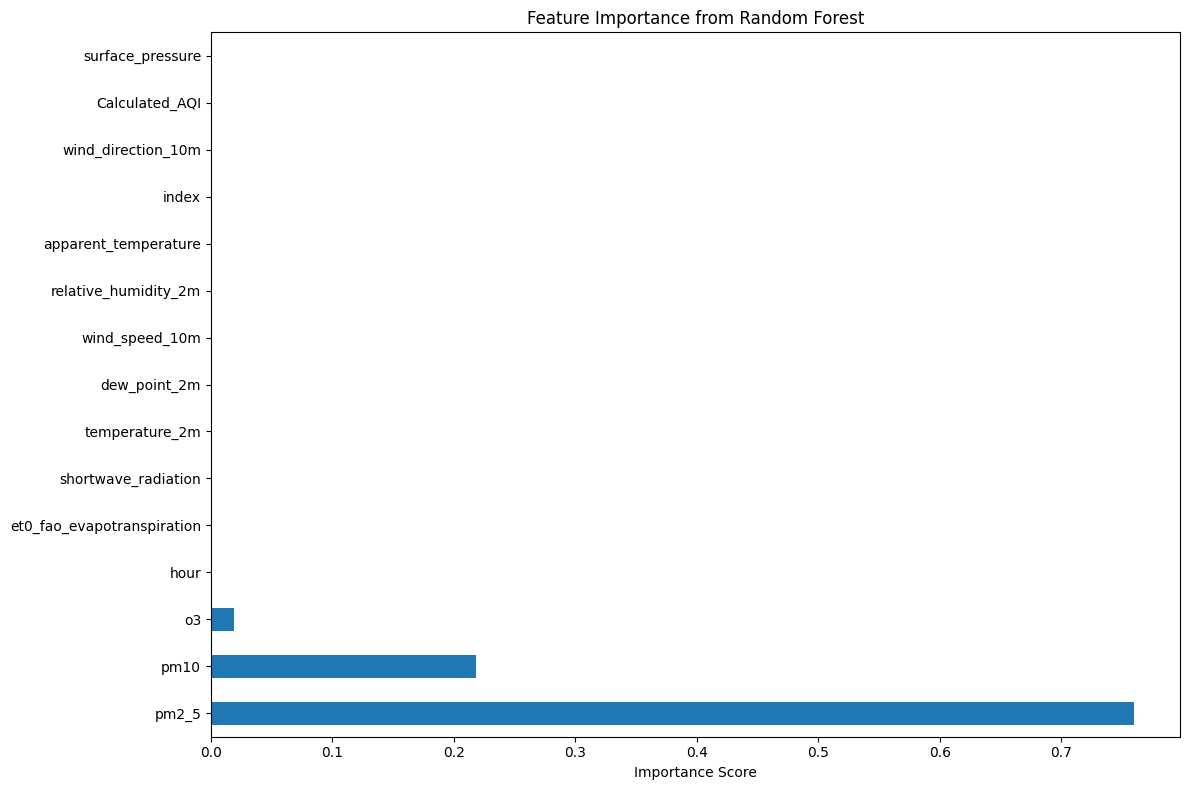

In [21]:
# Train a RandomForest model
# Using a sample for faster computation
sample_size = min(3000, len(X))
sample_indices = np.random.choice(len(X), sample_size, replace=False)

X_sample = X.iloc[sample_indices]
y_sample = y.iloc[sample_indices]

# Train the model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_sample, y_sample)

# Plot standard Random Forest feature importance
importances = model.feature_importances_
feat_importances = pd.Series(importances, index=X.columns)
feat_importances.sort_values(ascending=False, inplace=True)

plt.figure(figsize=(12, 8))
feat_importances.head(15).plot(kind='barh')
plt.title('Feature Importance from Random Forest')
plt.xlabel('Importance Score')
plt.tight_layout()
plt.show()

C:\Users\Dell\AppData\Local\Temp\ipykernel_4332\1491611391.py:13: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_shap, plot_type="bar", show=False)


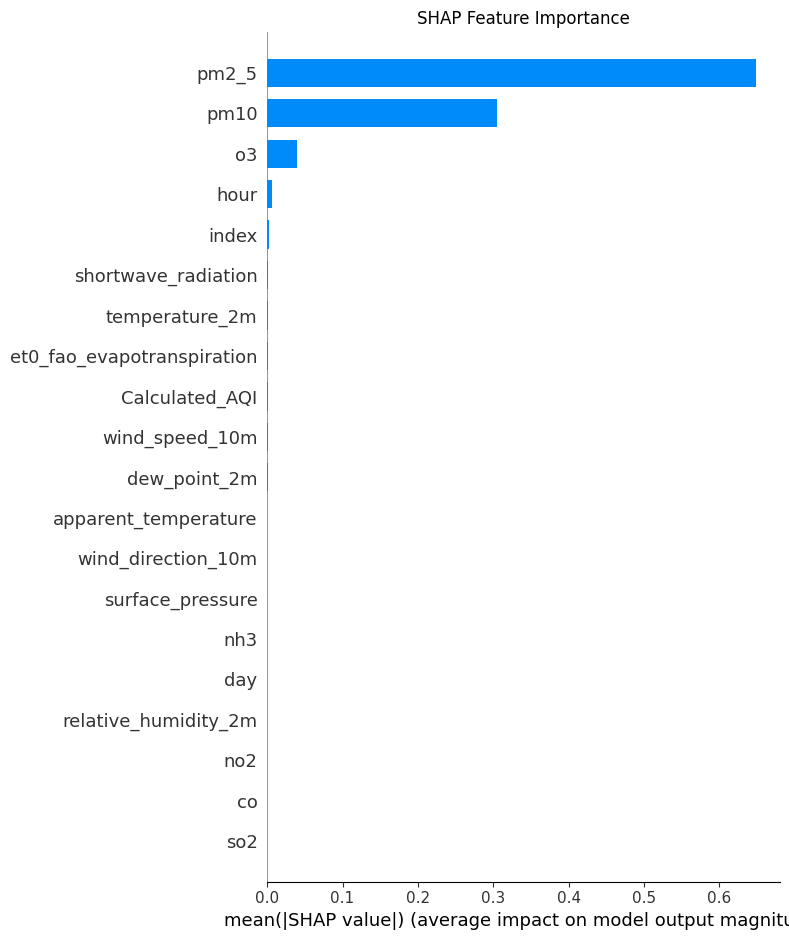

In [22]:
# Generate SHAP values
# Using a smaller subset for SHAP calculations (can be computationally intensive)
shap_sample_size = min(500, len(X_sample))
shap_indices = np.random.choice(len(X_sample), shap_sample_size, replace=False)
X_shap = X_sample.iloc[shap_indices]

# Create the SHAP explainer
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_shap)

# Generate bar summary plot
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values, X_shap, plot_type="bar", show=False)
plt.title('SHAP Feature Importance')
plt.tight_layout()
plt.show()

C:\Users\Dell\AppData\Local\Temp\ipykernel_4332\258668945.py:3: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_shap, show=False)


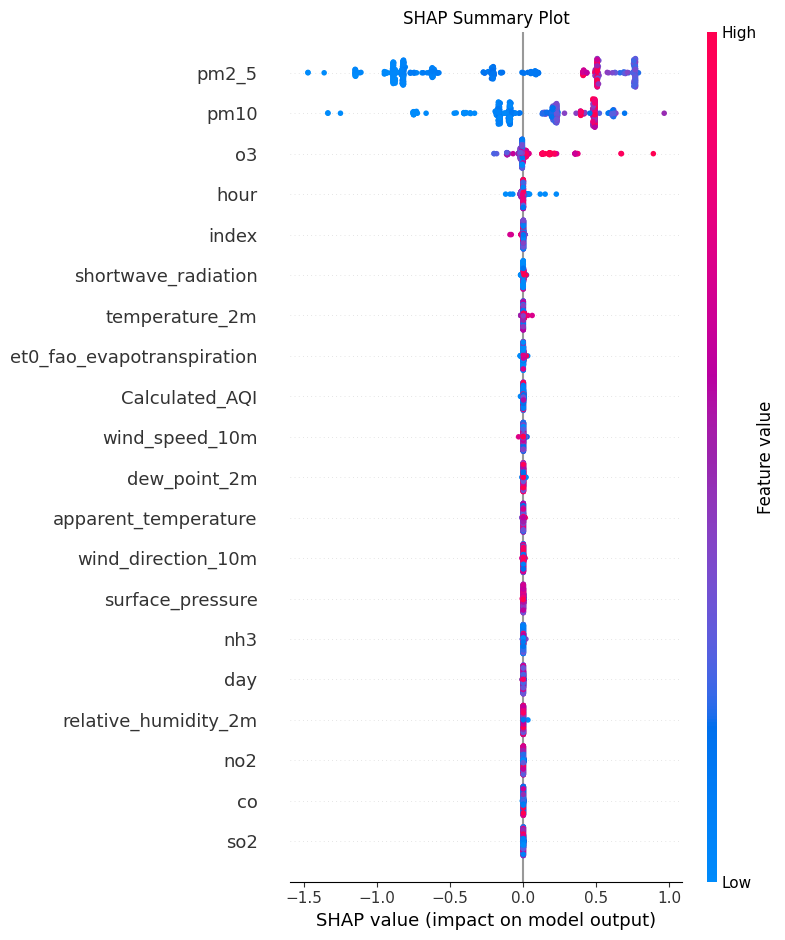

In [23]:
# SHAP Summary Plot (beeswarm) - shows both importance and effect direction
plt.figure(figsize=(12, 10))
shap.summary_plot(shap_values, X_shap, show=False)
plt.title('SHAP Summary Plot')
plt.tight_layout()
plt.show()

Top 5 features by SHAP importance: ['pm2_5', 'pm10', 'o3', 'hour', 'index']


<Figure size 1000x800 with 0 Axes>

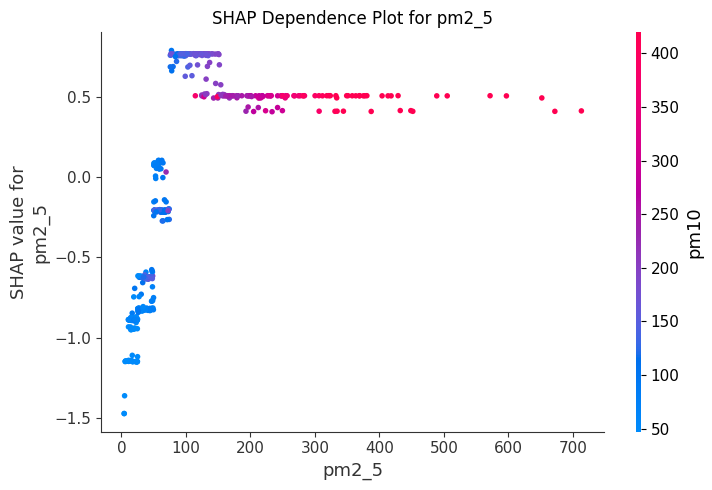

<Figure size 1000x800 with 0 Axes>

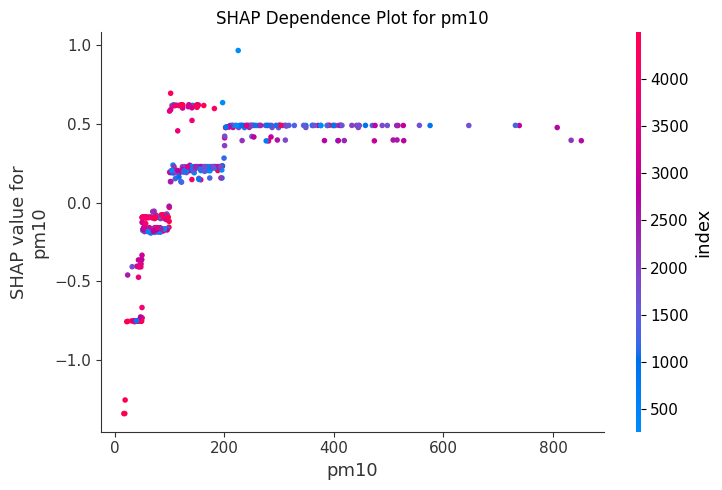

<Figure size 1000x800 with 0 Axes>

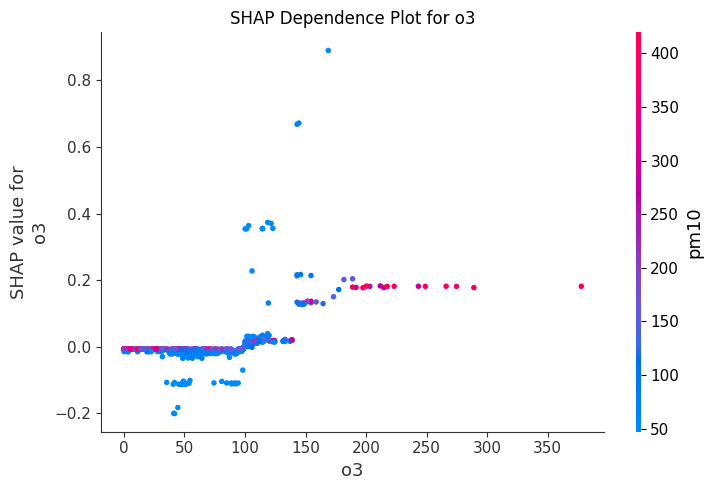

<Figure size 1000x800 with 0 Axes>

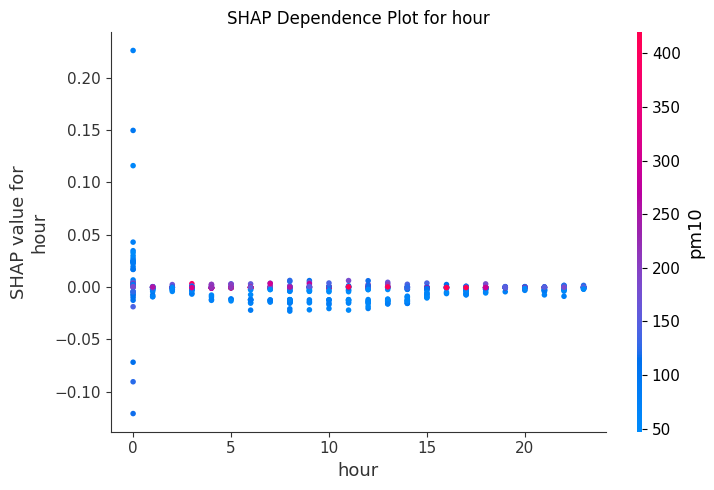

<Figure size 1000x800 with 0 Axes>

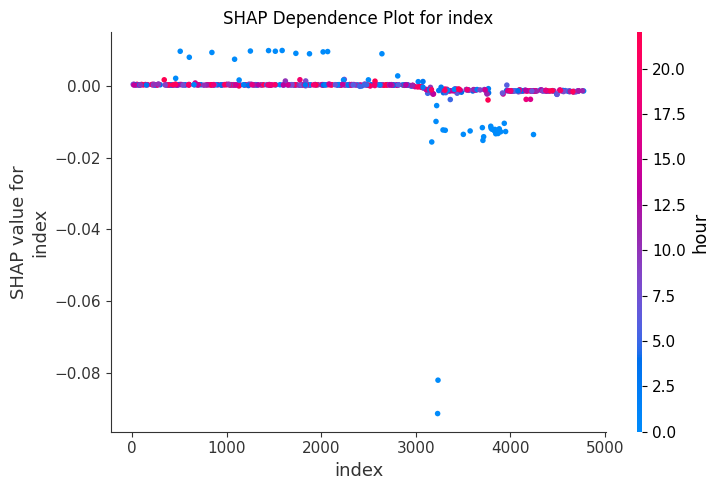

In [24]:
# Detailed analysis for top features
# Find the top 5 most important features based on SHAP values
mean_shap = np.abs(shap_values).mean(0)
feature_importance = pd.DataFrame(list(zip(X.columns, mean_shap)), columns=['Feature', 'SHAP Value'])
feature_importance.sort_values(by=['SHAP Value'], ascending=False, inplace=True)
top_features = feature_importance['Feature'].head(5).tolist()

print(f"Top 5 features by SHAP importance: {top_features}")

# Create dependence plots for top features
for feature in top_features:
    plt.figure(figsize=(10, 8))
    feature_idx = list(X.columns).index(feature)
    shap.dependence_plot(feature_idx, shap_values, X_shap, show=False)
    plt.title(f'SHAP Dependence Plot for {feature}')
    plt.tight_layout()
    plt.show()

<Figure size 2000x300 with 0 Axes>

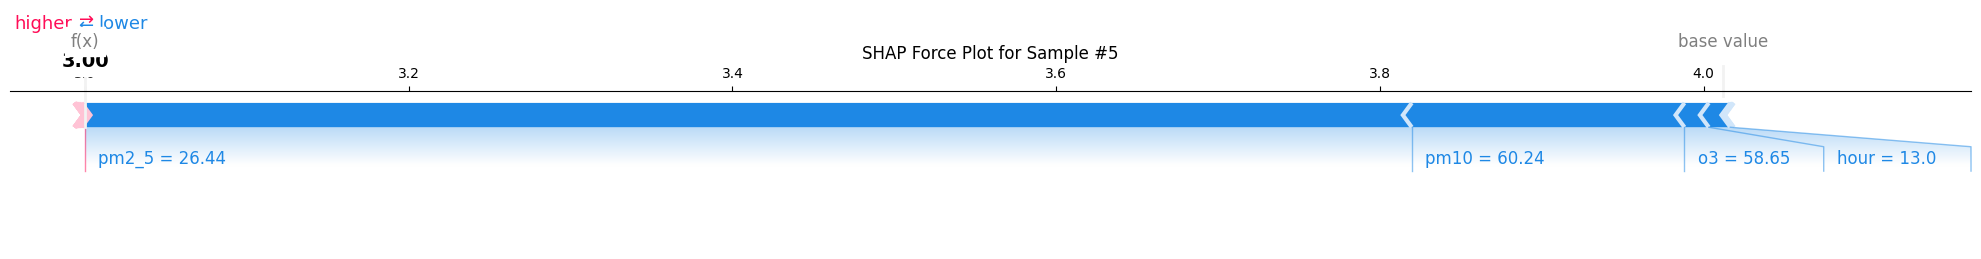

In [25]:
# Sample SHAP Force Plot for individual predictions
# Select a random sample
sample_idx = np.random.choice(len(X_shap))
plt.figure(figsize=(20, 3))
shap.force_plot(explainer.expected_value, shap_values[sample_idx,:], X_shap.iloc[sample_idx,:], 
               matplotlib=True, show=False)
plt.title(f'SHAP Force Plot for Sample #{sample_idx}')
plt.tight_layout()
plt.show()

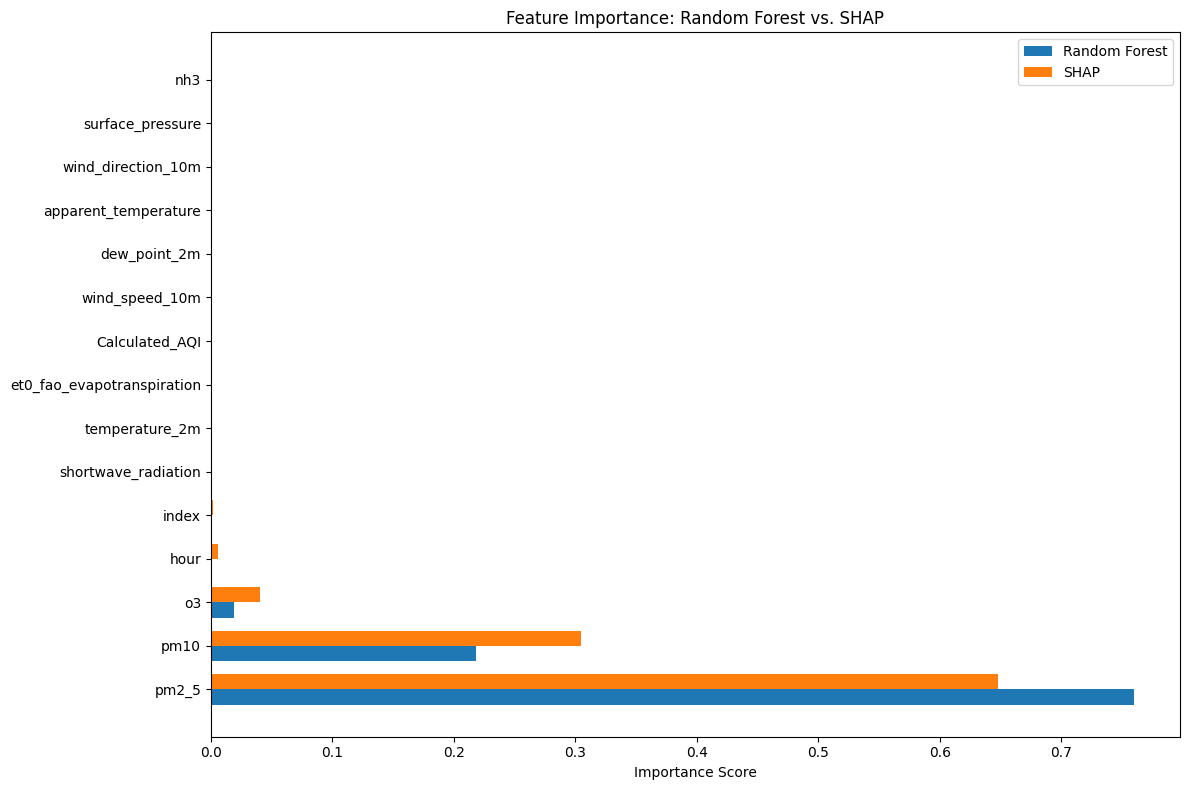

In [26]:
# Compare importance metrics (Random Forest vs SHAP)
rf_importance = pd.DataFrame({
    'Feature': X.columns,
    'Random Forest Importance': model.feature_importances_
})

combined_importance = rf_importance.merge(feature_importance, on='Feature')
combined_importance = combined_importance.sort_values('SHAP Value', ascending=False).head(15)

# Plot comparison
plt.figure(figsize=(12, 8))
bar_width = 0.35
index = np.arange(len(combined_importance))

plt.barh(index, combined_importance['Random Forest Importance'], bar_width, label='Random Forest')
plt.barh(index + bar_width, combined_importance['SHAP Value'], bar_width, label='SHAP')

plt.yticks(index + bar_width/2, combined_importance['Feature'])
plt.xlabel('Importance Score')
plt.title('Feature Importance: Random Forest vs. SHAP')
plt.legend()
plt.tight_layout()
plt.show()

In [27]:
# Print insights from SHAP analysis
print("\nKey Insights from SHAP Analysis:")
print("--------------------------------")
print(f"1. The top 5 most important features for predicting AQI index are: {', '.join(top_features)}")
print("2. SHAP values show how each feature contributes to pushing the prediction higher or lower")
print("3. The beeswarm plot shows both the importance magnitude and direction of influence")
print("4. Dependence plots reveal how the effect of each feature varies across its value range")
print("5. There are some differences between traditional Random Forest importance and SHAP values")


Key Insights from SHAP Analysis:
--------------------------------
1. The top 5 most important features for predicting AQI index are: pm2_5, pm10, o3, hour, index
2. SHAP values show how each feature contributes to pushing the prediction higher or lower
3. The beeswarm plot shows both the importance magnitude and direction of influence
4. Dependence plots reveal how the effect of each feature varies across its value range
5. There are some differences between traditional Random Forest importance and SHAP values


Least important features (lowest SHAP values):
          Feature    SHAP Value
11  precipitation  0.000000e+00
19           year  7.303186e-19
20          month  1.068484e-05
2              no  7.871701e-05
5             so2  8.975477e-05

Dropping the two least important features: ['precipitation', 'year']

Original feature count: 24
Reduced feature count: 22


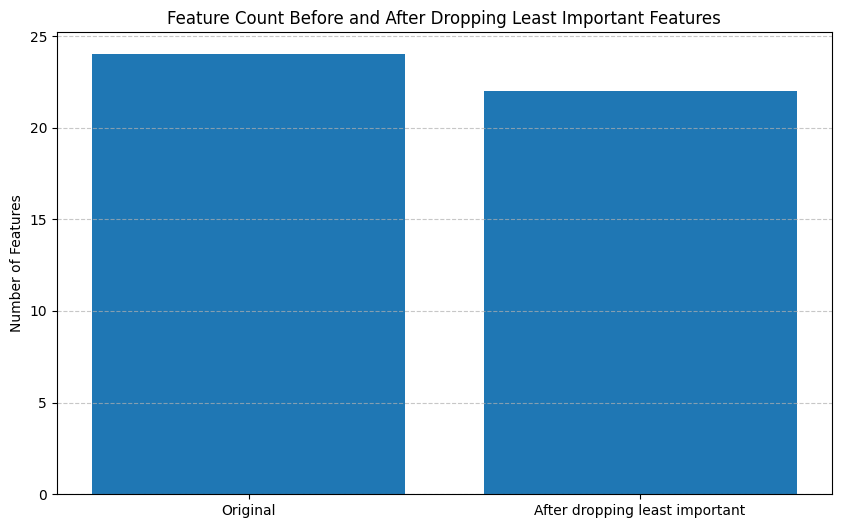


Model Performance Comparison:
Original model (all features):
  RMSE: 0.0662
  MSE: 0.0044 ± 0.0006
Reduced model (dropped 2 features):
  RMSE: 0.0682
  MSE: 0.0046 ± 0.0017

Performance change after dropping features: 2.97% RMSE


In [28]:
# Identify the least important features based on SHAP values
# First, ensure we have all features ranked by importance
all_feature_importance = pd.DataFrame(list(zip(X.columns, mean_shap)), 
                                     columns=['Feature', 'SHAP Value'])
all_feature_importance.sort_values(by=['SHAP Value'], ascending=True, inplace=True)

# Display the least important features
print("Least important features (lowest SHAP values):")
print(all_feature_importance.head(5))

# Identify the two least important features
least_important_features = all_feature_importance['Feature'].head(2).tolist()
print(f"\nDropping the two least important features: {least_important_features}")

# Create a new dataset without these features
X_reduced = X.drop(columns=least_important_features)
print(f"\nOriginal feature count: {X.shape[1]}")
print(f"Reduced feature count: {X_reduced.shape[1]}")

# Visualize the feature reduction
plt.figure(figsize=(10, 6))
plt.bar(['Original', 'After dropping least important'], [X.shape[1], X_reduced.shape[1]])
plt.title('Feature Count Before and After Dropping Least Important Features')
plt.ylabel('Number of Features')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Optional: Train a new model with reduced features to compare performance
sample_size_reduced = min(3000, len(X_reduced))
sample_indices_reduced = np.random.choice(len(X_reduced), sample_size_reduced, replace=False)

X_sample_reduced = X_reduced.iloc[sample_indices_reduced]
y_sample_reduced = y.iloc[sample_indices_reduced]

# Train a new model with reduced features
model_reduced = RandomForestRegressor(n_estimators=100, random_state=42)
model_reduced.fit(X_sample_reduced, y_sample_reduced)

# Compare performance using cross-validation
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, r2_score

# Function to evaluate and compare models
def evaluate_model(model, X, y, cv=5):
    cv_scores = cross_val_score(model, X, y, cv=cv, scoring='neg_mean_squared_error')
    mse_scores = -cv_scores  # Convert negative MSE to positive
    return {
        'MSE': mse_scores.mean(),
        'RMSE': np.sqrt(mse_scores.mean()),
        'MSE_std': mse_scores.std()
    }

# Evaluate both models
original_scores = evaluate_model(model, X_sample, y_sample)
reduced_scores = evaluate_model(model_reduced, X_sample_reduced, y_sample_reduced)

# Display results
print("\nModel Performance Comparison:")
print(f"Original model (all features):\n  RMSE: {original_scores['RMSE']:.4f}\n  MSE: {original_scores['MSE']:.4f} ± {original_scores['MSE_std']:.4f}")
print(f"Reduced model (dropped {len(least_important_features)} features):\n  RMSE: {reduced_scores['RMSE']:.4f}\n  MSE: {reduced_scores['MSE']:.4f} ± {reduced_scores['MSE_std']:.4f}")

# Calculate percentage change in performance
pct_change_rmse = 100 * (reduced_scores['RMSE'] - original_scores['RMSE']) / original_scores['RMSE']
print(f"\nPerformance change after dropping features: {pct_change_rmse:.2f}% RMSE")

In [ ]:
file_path = "../data/processed/cleaned_aqi_weather_dataset.csv"
s3_upload_key = "pipeline-data/data.csv"
# Upload the file
s3.upload_file(file_path, bucket_name, s3_upload_key)
print(f"Uploaded {file_path} to s3://{bucket_name}/{s3_upload_key}")

✅ Uploaded ../data/processed/cleaned_aqi_weather_dataset.csv to s3://my-feature-store-data/pipeline-data/data.csv
